<a href="https://colab.research.google.com/github/SJinji/reinforcement_project/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frozen Lake with Reinforcement Learning**
### BY Mengyu LIANG, Nhat Mai NGUYEN, Jinji SHEN

# **Building Environment**

In [87]:
import numpy as np
from copy import deepcopy
import enum
import torch
import time
import random
import matplotlib.pyplot as plt

In [99]:
# define the possible actions as an enumeration
class Action(enum.Enum):
    Left = 0
    Right = 1
    Up = 2
    Down = 3

# define the environment class
class Environment:
    def __init__(self):
        # initialize the map, which is a 4x4 grid of characters
        self.map = np.array([['S', 'F', 'F', 'F'], 
                             ['F', 'H', 'F', 'H'], 
                             ['F', 'F', 'F', 'H'], 
                             ['H', 'F', 'F', 'G']])
        # define the action space as an array of possible actions
        self.action_space = np.array([Action.Left, Action.Right, Action.Up, Action.Down])
        # define the state space as an array of integers from 0 to 15
        self.state_space = [i for i in range(np.array(self.map).size)]

        # define the states where certain actions are invalid (i.e. the agent would go off the map)
        self.no_left_states = [4, 8, 0, 12]
        self.no_right_states = [7, 11, 3, 15]
        self.no_up_states = [1, 2, 0, 3]
        self.no_down_states = [13, 14, 12, 15]

        # initialize the current state to be the top-left corner of the map
        self.current_state = 0

    # return the action space
    def get_action_space(self):
        return self.action_space

    # return the state space
    def get_state_space(self):
        return self.state_space

    # select a random action from the action space
    def get_random_action(self):
        return np.random.choice(self.action_space)

    # take a step in the environment, given an action index
    def step(self, action_index):
        # convert the action index to an Action enumeration
        action = Action(action_index)

        # check if the action is invalid (i.e. would make the agent go off the map)
        if self.invalid_action(action):
            # if so, return the current state, reward of 0, and False to indicate that the episode is not over
            return self.current_state, 0, False

        # update the current state based on the action
        if action == Action.Left:
            self.current_state -= 1
        elif action == Action.Right:
            self.current_state += 1
        elif action == Action.Up:
            self.current_state -= 4
        else:
            self.current_state += 4

        # get the row and column indices of the current state
        row, column = self.get_indices_of_current_state()
        # get the character at the current state's position on the map
        letter = self.map[row][column]

        # if the current state is a 'S' or 'F', return the current state, reward of 0, and False to indicate that the episode is not over
        if letter == 'S' or letter == 'F':
            return self.current_state, 0, False
        # if the current state is a 'G', return the current state, reward of 1, and True to indicate that the episode is over
        elif letter == 'G':
            return self.current_state, 1, True
        # if the current state is a 'H', return the current state, reward of 0, and True to indicate that the episode is over
        elif letter == 'H':
            return self.current_state, 0, True

    def invalid_action(self, action):
        # Check if the chosen action is not allowed in the current state
        if (action == Action.Left and self.current_state in self.no_left_states) or \
           (action == Action.Right and self.current_state in self.no_right_states) or \
           (action == Action.Up and self.current_state in self.no_up_states) or \
           (action == Action.Down and self.current_state in self.no_down_states):
            return True

        return False

    def get_indices_of_current_state(self):
        # Convert the current state to a row and column index on the map
        temp = 0
        for i in range(len(self.map)):
            for j in range(len(self.map[0])):
                if temp == self.current_state:
                    return i, j
                temp += 1

    def reset(self):
        # reset the current state to the starting state (which is 0 in this case) and returns the new current state
        self.current_state = 0
        return self.current_state

    def print_current_state(self):
        # make a copy of the map
        temp_map = deepcopy(self.map)
        row, column = self.get_indices_of_current_state()
        # replace the cell at the current state with an 'X' symbol in the copy
        temp_map[row][column] = 'X'

        # prints the map with the current state symbol to the console.
        for r in temp_map:
            print(r[0], r[1], r[2], r[3])
        print()

In [100]:
# create an instance of the Environment class
env = Environment()

# print the current state
env.print_current_state()

# take a step with a random action
action = env.get_random_action()
next_state, reward, done = env.step(action.value)
print("Action taken:", action)
print("Next state:", next_state)
print("Reward received:", reward)
print("Done?", done)

# reset the environment
env.reset()

X F F F
F H F H
F F F H
H F F G

Action taken: Action.Down
Next state: 4
Reward received: 0
Done? False


0

# **Q_learning**

In [80]:
env = Environment()
# Total number of States and Actions
number_of_states = len(env.get_state_space())
number_of_actions = len(env.get_action_space())
print( "States = ", number_of_states)
print( "Actions = ", number_of_actions)


States =  16
Actions =  4


In [81]:
num_episodes = 1000
steps_total = []
rewards_total = []
egreedy_total = []

# Discount on reward
gamma = 0.95

# Factor to balance the ratio of action taken based on past experience to current situtation
learning_rate = 0.9

In [82]:
# exploit vs explore to find action
# Start with 70% random actions to explore the environment
# And with time, using decay to shift to more optimal actions learned from experience

egreedy = 0.7
egreedy_final = 0.1
egreedy_decay = 0.999

In [83]:
Q = torch.zeros([number_of_states, number_of_actions])
Q

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [84]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        random_for_egreedy = torch.rand(1)[0]

        if random_for_egreedy > egreedy:      
            random_values = Q[state] + torch.rand(1,number_of_actions) / 1000      
            action = torch.max(random_values,1)[1][0]  
            action = action.item()
        else:
            action = env.get_random_action().value
                    
        if egreedy > egreedy_final:
            egreedy *= egreedy_decay

        new_state, reward, done = env.step(action)

        # Filling the Q Table
        Q[state, action] = reward + gamma * torch.max(Q[new_state])
        
        state = new_state
        
        # env.render()
        # time.sleep(0.4)
        
        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            egreedy_total.append(egreedy)
            #if i_episode % 10 == 0:
            print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break
        

Episode: 0 Reward: 0 Steps Taken: 3
Episode: 1 Reward: 1 Steps Taken: 8
Episode: 2 Reward: 0 Steps Taken: 24
Episode: 3 Reward: 0 Steps Taken: 7
Episode: 4 Reward: 0 Steps Taken: 12
Episode: 5 Reward: 0 Steps Taken: 14
Episode: 6 Reward: 0 Steps Taken: 2
Episode: 7 Reward: 0 Steps Taken: 6
Episode: 8 Reward: 0 Steps Taken: 5
Episode: 9 Reward: 0 Steps Taken: 5
Episode: 10 Reward: 0 Steps Taken: 3
Episode: 11 Reward: 0 Steps Taken: 2
Episode: 12 Reward: 0 Steps Taken: 5
Episode: 13 Reward: 0 Steps Taken: 3
Episode: 14 Reward: 0 Steps Taken: 2
Episode: 15 Reward: 0 Steps Taken: 8
Episode: 16 Reward: 0 Steps Taken: 7
Episode: 17 Reward: 0 Steps Taken: 24
Episode: 18 Reward: 0 Steps Taken: 8
Episode: 19 Reward: 0 Steps Taken: 9
Episode: 20 Reward: 0 Steps Taken: 10
Episode: 21 Reward: 0 Steps Taken: 11
Episode: 22 Reward: 0 Steps Taken: 23
Episode: 23 Reward: 0 Steps Taken: 20
Episode: 24 Reward: 0 Steps Taken: 2
Episode: 25 Reward: 0 Steps Taken: 6
Episode: 26 Reward: 0 Steps Taken: 2
Epi

In [85]:
print(Q)
        
print("Percent of episodes finished successfully: {0}".format(sum(rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(rewards_total[-100:])/100))

print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))


tensor([[0.7351, 0.7738, 0.7351, 0.7738],
        [0.7351, 0.8145, 0.7738, 0.0000],
        [0.7738, 0.7738, 0.8145, 0.8574],
        [0.8145, 0.7738, 0.7738, 0.0000],
        [0.7738, 0.0000, 0.7351, 0.8145],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8145, 0.9025],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.8145, 0.8574, 0.7738, 0.0000],
        [0.8145, 0.9025, 0.0000, 0.9025],
        [0.8574, 0.0000, 0.8574, 0.9500],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9500, 0.8574, 0.9025],
        [0.9025, 1.0000, 0.9025, 0.9500],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Percent of episodes finished successfully: 0.798
Percent of episodes finished successfully (last 100 episodes): 0.92
Average number of steps: 6.49
Average number of steps (last 100 episodes): 6.32


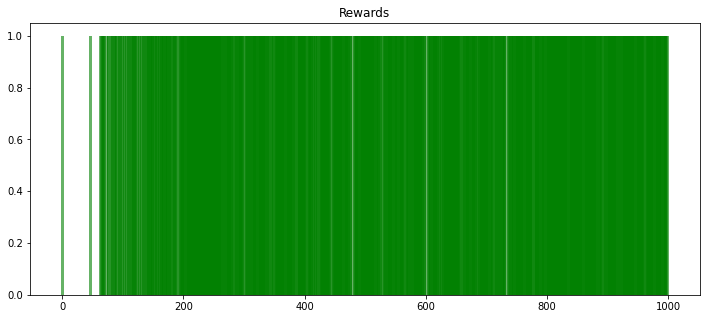

In [88]:
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total, alpha=0.6, color='green', width=5)
plt.show()

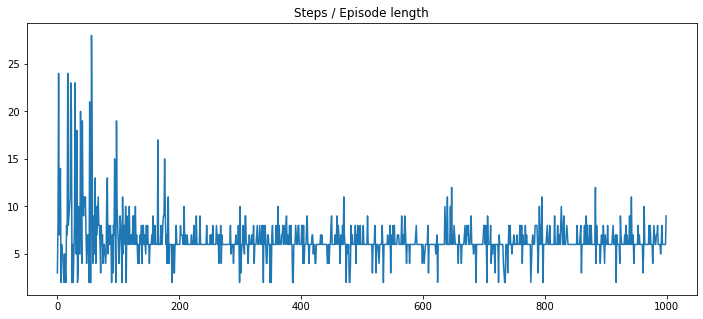

In [98]:
plt.figure(figsize=(12,5))
plt.title("Steps / Episode length")
x_axis = [i for i in range(num_episodes)]
y_axis = steps_total
plt.plot(x_axis,y_axis)
plt.show()

We can see that at the beginning the steps taken in an episode is large because we have high number of random actions. As we learn from experience, we start to take more informed steps , hence resulting is fewer steps and more success rate.

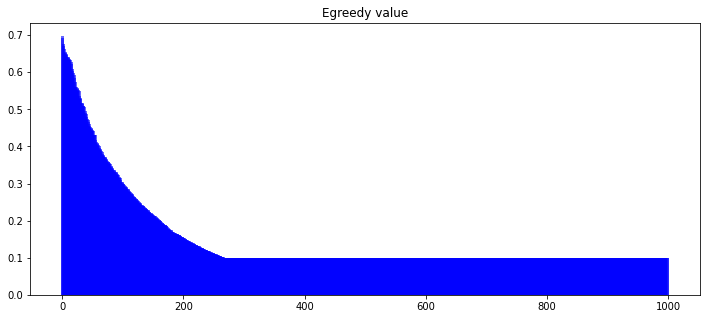

In [101]:
plt.figure(figsize=(12,5))
plt.title("Egreedy value")
plt.bar(torch.arange(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue', width=5)
plt.show()